In [1]:
import pandas as pd

df = pd.read_csv("dataR2.csv")

display(df.head())

print("\nDataset Summary:")
print(df.describe())

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1



Dataset Summary:
              Age         BMI     Glucose     Insulin        HOMA      Leptin  \
count  116.000000  116.000000  116.000000  116.000000  116.000000  116.000000   
mean    57.301724   27.582111   97.793103   10.012086    2.694988   26.615080   
std     16.112766    5.020136   22.525162   10.067768    3.642043   19.183294   
min     24.000000   18.370000   60.000000    2.432000    0.467409    4.311000   
25%     45.000000   22.973205   85.750000    4.359250    0.917966   12.313675   
50%     56.000000   27.662416   92.000000    5.924500    1.380939   20.271000   
75%     71.000000   31.241442  102.000000   11.189250    2.857787   37.378300   
max     89.000000   38.578759  201.000000   58.460000   25.050342   90.280000   

       Adiponectin    Resistin        MCP.1  Classification  
count   116.000000  116.000000   116.000000      116.000000  
mean     10.180874   14.725966   534.647000        1.551724  
std       6.843341   12.390646   345.912663        0.499475  
min 

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE   
from sklearn.model_selection import GridSearchCV

***NAIVE APPROACH WITH SOME PARAMETERS***


In [3]:
# Defining features
X = df.drop(columns=['Classification']) 
y = df['Classification']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Defining models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "k-NN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000)
}

# Performing 10-fold cross-validation and collecting results
results = []
for name, model in models.items():
    accuracy = np.mean(cross_val_score(model, X_scaled, y, cv=10, scoring='accuracy'))
    precision = np.mean(cross_val_score(model, X_scaled, y, cv=10, scoring='precision_weighted'))
    recall = np.mean(cross_val_score(model, X_scaled, y, cv=10, scoring='recall_weighted'))
    f1 = np.mean(cross_val_score(model, X_scaled, y, cv=10, scoring='f1_weighted'))
    results.append([name, accuracy, precision, recall, f1])

# Baseline classifier
majority_class = y.mode()[0]
baseline_preds = np.full(y.shape, majority_class)
baseline_acc = accuracy_score(y, baseline_preds)
baseline_prec = precision_score(y, baseline_preds, average='weighted', zero_division=0)
baseline_recall = recall_score(y, baseline_preds, average='weighted', zero_division=0)
baseline_f1 = f1_score(y, baseline_preds, average='weighted', zero_division=0)
results.insert(0, ["Baseline Classifier", baseline_acc, baseline_prec, baseline_recall, baseline_f1])

results_df = pd.DataFrame(results, columns=["Algorithm", "C.C.I.%", "Precision", "Recall", "F-measure"])
print(results_df)

             Algorithm   C.C.I.%  Precision    Recall  F-measure
0  Baseline Classifier  0.551724   0.304400  0.551724   0.392337
1  Logistic Regression  0.687879   0.721989  0.687879   0.665287
2        Decision Tree  0.696212   0.662597  0.714394   0.701713
3           k-NN (k=5)  0.650000   0.639278  0.650000   0.629348
4       Neural Network  0.693939   0.718056  0.677273   0.660399


***LOGISTIC REGRESSION***


In [4]:
# Tries of different Hyperparameter for Logistic Regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 50, 100, 200],  
    'solver': ['liblinear', 'newton-cg'],  
    'max_iter': [5000, 10000, 20000, 50000]  
}

log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=10, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], refit=False, n_jobs=-1)
grid_search.fit(X_scaled, y)

# Collecting all the results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results[['param_C', 'param_solver', 'param_max_iter', 'mean_test_accuracy', 'mean_test_precision_weighted', 'mean_test_recall_weighted', 'mean_test_f1_weighted']]
cv_results.columns = ["C", "Solver", "Max Iterations", "C.C.I.%", "Precision", "Recall", "F-measure"]


# Finding and printing the best parameters
best_params_logreg = cv_results.loc[cv_results['Precision'].idxmax()]
print("Best Parameters based on Precision:")
print(best_params_logreg)

Best Parameters based on Precision:
C                      10.0
Solver            liblinear
Max Iterations         5000
C.C.I.%            0.696212
Precision          0.724716
Recall             0.696212
F-measure          0.678207
Name: 32, dtype: object


***DECISION TREE***

In [5]:
# Tries of different Hyperparameter for Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy'],  
    'max_depth': [10, 20, 30, 50],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 5]  
}

dt = DecisionTreeClassifier()
grid_search = GridSearchCV(dt, param_grid, cv=10, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], refit=False, n_jobs=-1)
grid_search.fit(X_scaled, y)

# Collecting all results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results[['param_criterion', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_accuracy', 'mean_test_precision_weighted', 'mean_test_recall_weighted', 'mean_test_f1_weighted']]
cv_results.columns = ["Criterion", "Max Depth", "Min Samples Split", "Min Samples Leaf", "C.C.I.%", "Precision", "Recall", "F-measure"]


# Finding and printing the best parameters
best_params_dt = cv_results.loc[cv_results['Precision'].idxmax()]
print("Best Parameters based on Precision:")
print(best_params_dt)

Best Parameters based on Precision:
Criterion             entropy
Max Depth                  50
Min Samples Split          10
Min Samples Leaf            5
C.C.I.%              0.759848
Precision            0.809842
Recall               0.759848
F-measure            0.750836
Name: 71, dtype: object


***KNN***


In [6]:
# Tries of different Hyperparameter for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],  
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan', 'minkowski'] 
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], refit=False, n_jobs=-1)
grid_search.fit(X_scaled, y)

# Collecting all results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results[['param_n_neighbors', 'param_weights', 'param_metric', 'mean_test_accuracy', 'mean_test_precision_weighted', 'mean_test_recall_weighted', 'mean_test_f1_weighted']]
cv_results.columns = ["k Neighbors", "Weights", "Metric", "C.C.I.%", "Precision", "Recall", "F-measure"]


# Finding and printing the best parameters
best_params_knn = cv_results.loc[cv_results['Precision'].idxmax()]
print("Best Parameters based on Precision:")
print(best_params_knn)


Best Parameters based on Precision:
k Neighbors           15
Weights         distance
Metric         manhattan
C.C.I.%         0.720455
Precision       0.751593
Recall          0.720455
F-measure       0.706988
Name: 23, dtype: object


***ARTIFICIAL NEURAL NETWORKS***

In [7]:
# Tries of different Hyperparameter for Artificial Neural Networks
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (10,10), (20,10)],  
    'activation': ['relu', 'tanh', 'logistic'], 
    'solver': ['adam', 'sgd'],
    'max_iter': [2000, 5000, 10000] 
}

mlp = MLPClassifier()
grid_search = GridSearchCV(mlp, param_grid, cv=10, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], refit=False, n_jobs=-1)
grid_search.fit(X_scaled, y)

# Collecting all results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results[['param_hidden_layer_sizes', 'param_activation', 'param_solver', 'param_max_iter', 'mean_test_accuracy', 'mean_test_precision_weighted', 'mean_test_recall_weighted', 'mean_test_f1_weighted']]
cv_results.columns = ["Hidden Layers", "Activation", "Solver", "Max Iterations", "C.C.I.%", "Precision", "Recall", "F-measure"]


# Finding and printing the best parameters
best_params_mlp = cv_results.loc[cv_results['Precision'].idxmax()]
print("Best Parameters based on Precision:")
print(best_params_mlp)

Best Parameters based on Precision:
Hidden Layers     (10, 10)
Activation            tanh
Solver                 sgd
Max Iterations        2000
C.C.I.%           0.754545
Precision         0.789305
Recall            0.754545
F-measure         0.740162
Name: 37, dtype: object


***RESULTS***

In [8]:
# Baseline Classifier (Majority Class Predictor)
majority_class = y.mode()[0]
baseline_preds = np.full(y.shape, majority_class)
baseline_acc = accuracy_score(y, baseline_preds)
baseline_prec = precision_score(y, baseline_preds, average='weighted', zero_division=0)
baseline_recall = recall_score(y, baseline_preds, average='weighted', zero_division=0)
baseline_f1 = f1_score(y, baseline_preds, average='weighted', zero_division=0)

results = [
    ["Baseline Classifier", baseline_acc, baseline_prec, baseline_recall, baseline_f1],
    ["Logistic Regression", best_params_logreg["C.C.I.%"], best_params_logreg["Precision"], best_params_logreg["Recall"], best_params_logreg["F-measure"]],
    ["Decision Tree", best_params_dt["C.C.I.%"], best_params_dt["Precision"], best_params_dt["Recall"], best_params_dt["F-measure"]],
    ["k-NN", best_params_knn["C.C.I.%"], best_params_knn["Precision"], best_params_knn["Recall"], best_params_knn["F-measure"]],
    ["Neural Network", best_params_mlp["C.C.I.%"], best_params_mlp["Precision"], best_params_mlp["Recall"], best_params_mlp["F-measure"]]
]

results_df = pd.DataFrame(results, columns=["Algorithm", "C.C.I.%", "Precision", "Recall", "F-measure"])
print(results_df)

             Algorithm   C.C.I.%  Precision    Recall  F-measure
0  Baseline Classifier  0.551724   0.304400  0.551724   0.392337
1  Logistic Regression  0.696212   0.724716  0.696212   0.678207
2        Decision Tree  0.759848   0.809842  0.759848   0.750836
3                 k-NN  0.720455   0.751593  0.720455   0.706988
4       Neural Network  0.754545   0.789305  0.754545   0.740162


***OVERFITTING***

In [9]:
df = pd.read_csv("dataR2.csv")  
X = df.drop(columns=['Classification'])  
y = df['Classification']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Applying the models with their corresponding best parameters
models = {
    "Logistic Regression": LogisticRegression(C=10.0, solver='liblinear', max_iter=5000),
    "Decision Tree": DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=10, min_samples_leaf=5),
    "k-NN (k=15)": KNeighborsClassifier(n_neighbors=15, weights='distance', metric='manhattan'),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='adam', max_iter=5000)
}

# Training models and comparing train/test performance
overfitting_results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    overfitting_results.append([name, train_acc, test_acc])


overfitting_df = pd.DataFrame(overfitting_results, columns=["Algorithm", "Train Accuracy", "Test Accuracy"])
print("Overfitting Analysis:")
print(overfitting_df)


Overfitting Analysis:
             Algorithm  Train Accuracy  Test Accuracy
0  Logistic Regression        0.760870       0.875000
1        Decision Tree        0.869565       0.916667
2          k-NN (k=15)        1.000000       0.875000
3       Neural Network        0.771739       0.833333


***FEATURE SELECTION***


In [11]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE


df = pd.read_csv("dataR2.csv")  # Ensure this file is in your working directory
X = df.drop(columns=['Classification'])
y = df['Classification']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying Filter Methods (ANOVA F-score and Mutual Information)
anova_selector = SelectKBest(score_func=f_classif, k=9)
anova_selector.fit(X_scaled, y)
anova_scores = anova_selector.scores_

mutual_info_selector = SelectKBest(score_func=mutual_info_classif, k=9)
mutual_info_selector.fit(X_scaled, y)
mutual_info_scores = mutual_info_selector.scores_

# Applying Wrapper Method (Recursive Feature Elimination - RFE)
rfe_selector = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=9)
rfe_selector.fit(X_scaled, y)
rfe_ranking = rfe_selector.ranking_

feature_names = X.columns
feature_ranking = pd.DataFrame({
    "Feature": feature_names,
    "ANOVA Score": anova_scores,
    "Mutual Info Score": mutual_info_scores,
    "RFE Ranking": rfe_ranking
}).sort_values(by="ANOVA Score", ascending=False)

print("Feature Selection Rankings:")
print(feature_ranking)


Feature Selection Rankings:
       Feature  ANOVA Score  Mutual Info Score  RFE Ranking
2      Glucose    19.755454           0.088309            1
4         HOMA    10.002398           0.016421            1
3      Insulin     9.459504           0.000000            1
7     Resistin     6.211315           0.057669            1
1          BMI     2.039862           0.000000            1
8        MCP.1     0.959962           0.000000            1
0          Age     0.216670           0.109826            1
6  Adiponectin     0.043322           0.000000            1
5       Leptin     0.000133           0.000000            1


In [12]:
# Printing the top 5 most important features 
top_5_features = feature_ranking.head(5)[["Feature", "ANOVA Score"]]
features_text = ", ".join([f"{row['Feature']} (Score: {row['ANOVA Score']:.4f})" for _, row in top_5_features.iterrows()])
print(f"Top 5 Most Important Features Based on ANOVA Score: {features_text}")


Top 5 Most Important Features Based on ANOVA Score: Glucose (Score: 19.7555), HOMA (Score: 10.0024), Insulin (Score: 9.4595), Resistin (Score: 6.2113), BMI (Score: 2.0399)


In [14]:
from itertools import combinations
df = pd.read_csv("dataR2.csv")  
y = df['Classification']
scaler = StandardScaler()

# Generating different feature combinations (3 to 5 features)
feature_combinations = []
for n in range(3, 6):  # Selecting combinations of 3, 4, or 5 features
    feature_combinations.extend(list(combinations(top_5_features["Feature"], n)))


feature_selection_results = []
for selected_features in feature_combinations:
    X_selected = df[list(selected_features)]

    X_selected_scaled = scaler.fit_transform(X_selected)
    models = {
        "Logistic Regression": LogisticRegression(C=10.0, solver='liblinear', max_iter=5000),
        "Decision Tree": DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=10, min_samples_leaf=5),
        "k-NN (k=15)": KNeighborsClassifier(n_neighbors=15, weights='distance', metric='manhattan'),
        "Neural Network": MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='adam', max_iter=5000)
    }
    for name, model in models.items():
        cci = np.mean(cross_val_score(model, X_selected_scaled, y, cv=10, scoring='accuracy'))  # Compute C.C.I.%
        feature_selection_results.append([name, selected_features, cci])

feature_selection_df = pd.DataFrame(feature_selection_results, columns=["Model", "Selected Features", "C.C.I.%"])
print("Feature Selection Model Performance (Using C.C.I.% with 10-Fold Cross-Validation):")
print(feature_selection_df)

Feature Selection Model Performance (Using C.C.I.% with 10-Fold Cross-Validation):
                  Model                        Selected Features   C.C.I.%
0   Logistic Regression                 (Glucose, HOMA, Insulin)  0.703788
1         Decision Tree                 (Glucose, HOMA, Insulin)  0.569697
2           k-NN (k=15)                 (Glucose, HOMA, Insulin)  0.687879
3        Neural Network                 (Glucose, HOMA, Insulin)  0.687121
4   Logistic Regression                (Glucose, HOMA, Resistin)  0.723485
..                  ...                                      ...       ...
59       Neural Network           (HOMA, Insulin, Resistin, BMI)  0.695455
60  Logistic Regression  (Glucose, HOMA, Insulin, Resistin, BMI)  0.756818
61        Decision Tree  (Glucose, HOMA, Insulin, Resistin, BMI)  0.688636
62          k-NN (k=15)  (Glucose, HOMA, Insulin, Resistin, BMI)  0.712879
63       Neural Network  (Glucose, HOMA, Insulin, Resistin, BMI)  0.728788

[64 rows x 3 col

In [15]:
# Identifying and printing the best feature combinations for each model
best_cases = feature_selection_df.loc[feature_selection_df.groupby("Model")["C.C.I.%"].idxmax()]
print("\nBest Feature Combinations for Each Model (Using C.C.I.% with 10-Fold Cross-Validation):")
for _, row in best_cases.iterrows():
    print(f"{row['Model']}: Features {row['Selected Features']} → C.C.I.%: {row['C.C.I.%']:.4f}")

# Identifying and printing the top 5 best C.C.I.% scores overall
top_5_cases = feature_selection_df.nlargest(5, "C.C.I.%")
print("\nTop 5 Best C.C.I.% Scores Across All Models:")
for _, row in top_5_cases.iterrows():
    print(f"{row['Model']}: Features {row['Selected Features']} → C.C.I.%: {row['C.C.I.%']:.4f}")



Best Feature Combinations for Each Model (Using C.C.I.% with 10-Fold Cross-Validation):
Decision Tree: Features ('Glucose', 'Resistin', 'BMI') → C.C.I.%: 0.7235
Logistic Regression: Features ('Glucose', 'HOMA', 'Resistin', 'BMI') → C.C.I.%: 0.7742
Neural Network: Features ('Glucose', 'Resistin', 'BMI') → C.C.I.%: 0.7568
k-NN (k=15): Features ('Glucose', 'Resistin', 'BMI') → C.C.I.%: 0.7598

Top 5 Best C.C.I.% Scores Across All Models:
Logistic Regression: Features ('Glucose', 'HOMA', 'Resistin', 'BMI') → C.C.I.%: 0.7742
k-NN (k=15): Features ('Glucose', 'Resistin', 'BMI') → C.C.I.%: 0.7598
Neural Network: Features ('Glucose', 'Resistin', 'BMI') → C.C.I.%: 0.7568
Logistic Regression: Features ('Glucose', 'Insulin', 'Resistin', 'BMI') → C.C.I.%: 0.7568
Logistic Regression: Features ('Glucose', 'HOMA', 'Insulin', 'Resistin', 'BMI') → C.C.I.%: 0.7568


***LEARNING CURVE***

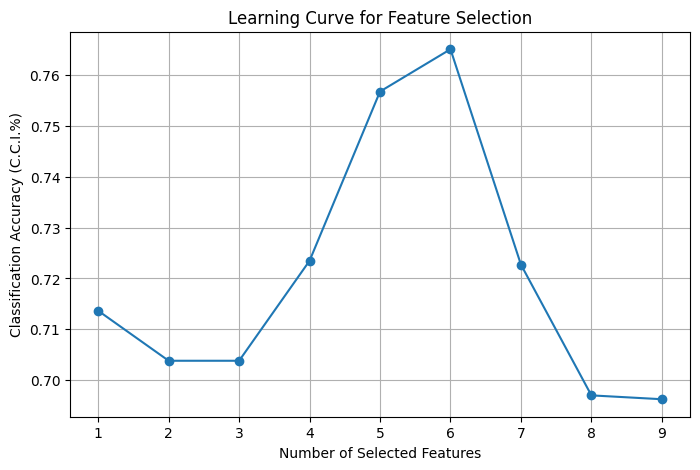

In [17]:
import matplotlib.pyplot as plt

learning_curve_results = []

for num_features in range(1, 10):  # 1 to 9 features
    selected_features = feature_ranking["Feature"][:num_features]
    X_selected = df[selected_features]
    
    X_selected_scaled = scaler.fit_transform(X_selected)
    model = LogisticRegression(C=10.0, solver='liblinear', max_iter=5000)
    cci = np.mean(cross_val_score(model, X_selected_scaled, y, cv=10, scoring='accuracy'))  # Compute C.C.I.%
    learning_curve_results.append((num_features, cci))

learning_curve_df = pd.DataFrame(learning_curve_results, columns=["Num Features", "C.C.I.%"])
plt.figure(figsize=(8,5))
plt.plot(learning_curve_df["Num Features"], learning_curve_df["C.C.I.%"], marker='o', linestyle='-')
plt.xlabel("Number of Selected Features")
plt.ylabel("Classification Accuracy (C.C.I.%)")
plt.title("Learning Curve for Feature Selection")
plt.grid(True)
plt.show()
